In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
# Project name used for jovian.commit
project_name = '03-cifar10-feedforward'

In [3]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Files already downloaded and verified


In [4]:
image,label = dataset[0]
print('image.shape:', image.shape)


image.shape: torch.Size([3, 32, 32])


image.shape: torch.Size([3, 32, 32])
Label: 6


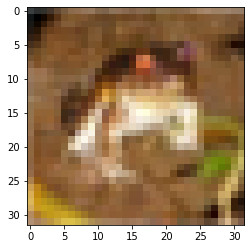

In [124]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

Next, let's use the random_split helper function to set aside 10000 images for our validation set.

In [5]:
val_size = 10000
train_size =len(dataset)-val_size

train_ds, val_ds =random_split(dataset, [train_size, val_size])
len(train_ds),len(val_ds)

(40000, 10000)

We can now create PyTorch data loaders for training and validation.

In [6]:
batch_size = 128

In [7]:
train_loader = DataLoader(train_ds,
                          batch_size, shuffle=True, num_workers=4,
                          pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
train_loader,val_loader

(<torch.utils.data.dataloader.DataLoader at 0x129ba3df0>,
 <torch.utils.data.dataloader.DataLoader at 0x129ba37c0>)

Let's visualize a batch of data in a grid using the make_grid function from torchvision. We'll also use the .permute method on the tensor to move the channels to the last dimension, as expected by matplotlib.

images,shape: torch.Size([128, 3, 32, 32])


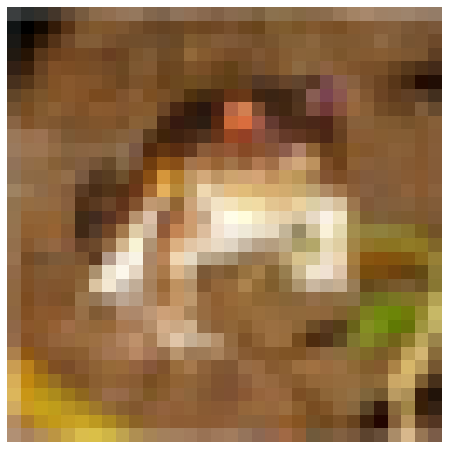

In [8]:
for images, _ in train_loader:
    print('images,shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(image,nrow=16).permute((1,2,0)))
    break

Hidden Layers, Activation Functions and Non-Linearity
how hidden layers and activation functions can help capture non-linear relationships between inputs and outputs.


First, let's create a batch of inputs tensors. We'll flatten the 3x28x28 images into vectors of size 3072, so they can be passed into an nn.Linear object.

In [9]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1,3072)
    print('imputs.shape:',inputs.shape)
    break

images.shape: torch.Size([128, 3, 32, 32])
imputs.shape: torch.Size([128, 3072])


Next, let's create a nn.Linear object, which will serve as our hidden layer. We'll set the size of the output from the hidden layer to 64. This number can be increased or decreased to change the learning capacity of the model.

In [15]:
input_size = inputs.shape[-1]
hidden_size =64

In [16]:
layer1 = nn.Linear(input_size, hidden_size)

We can now compute intermediate outputs for the batch of images by passing inputs through layer1.

In [14]:
inputs.shape


torch.Size([128, 3072])

In [17]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:',layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 64])


The image vectors of size 3072 are transformed into intermediate output vectors of length 64 by performing a matrix multiplication of inputs matrix with the transposed weights matrix of layer1 and adding the bias. We can verify this using torch.allclose

In [18]:
layer1_outputs_direct = inputs @layer1.weight.t()+layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 64])

In [19]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Thus, layer1_outputs and inputs have a linear relationship, i.e., each element of layer_outputs is a weighted sum of elements from inputs. Thus, even as we train the model and modify the weights, layer1 can only capture linear relationships between inputs and outputs.

use the F.relu method to apply ReLU to the elements of a tensor.

In [20]:
F.relu(torch.tensor([[1,-2,0],[-0.1,.2,3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

apply the activation function to layer1_outputs and verify that negative values were replaced with 0.

In [21]:
relu_outputs=F.relu(layer1_outputs)
print('min(layer1_outputs):',torch.min(layer1_outputs).item())
print('min(relu_outputs):',torch.min(relu_outputs).item())

min(layer1_outputs): -1.0624074935913086
min(relu_outputs): 0.0


let's create an output layer to convert vectors of length hidden_size in relu_outputs into vectors of length 10, which is the desired output of our model (since there are 10 target labels).

In [22]:
output_size =10
layer2 =nn.Linear(hidden_size, output_size)

In [23]:
layer2_ouputs=layer2(relu_outputs)
print(layer2_ouputs)

tensor([[-0.0850, -0.0764,  0.0729,  ...,  0.2728, -0.1638,  0.0842],
        [-0.0430,  0.0080,  0.0527,  ...,  0.2132, -0.0667,  0.0375],
        [-0.1180, -0.0554,  0.1183,  ...,  0.2871, -0.0663,  0.0734],
        ...,
        [-0.0859, -0.0498,  0.0747,  ...,  0.2760, -0.0207,  0.1013],
        [-0.1447, -0.1289,  0.0115,  ...,  0.2445,  0.0926,  0.0839],
        [-0.0918, -0.0907,  0.1268,  ...,  0.2637, -0.0866,  0.0749]],
       grad_fn=<AddmmBackward>)


layer2_outputs contains a batch of vectors of size 10. We can now use this output to compute the loss using F.cross_entropy and adjust the weights of layer1 and layer2 using gradient descent.

In [24]:
F.cross_entropy(layer2_ouputs,labels)

tensor(2.3228, grad_fn=<NllLossBackward>)

our model transforms inputs into layer2_outputs by applying a linear transformation (using layer1), followed by a non-linear activation (using F.relu), followed by another linear transformation (using layer2). Let's verify this by re-computing the output using basic matrix operations.

In [25]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs =( F.relu(inputs@layer1.weight.t()+layer1.bias))@layer2.weight.t()+layer2.bias

In [26]:
torch.allclose(outputs,layer2_ouputs,1e-3)

True

Note that outputs and inputs do not have a linear relationship due to the non-linear activation function F.relu. As we train the model and adjust the weights of layer1 and layer2, we can now capture non-linear relationships between the images and their labels. In other words, introducing non-linearity makes the model more powerful and versatile. Also, since hidden_size does not depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters within the model. We can also introduce new hidden layers and apply the same non-linear activation after each hidden layer.
The model we just created is called a neural network. A deep neural network is simply a neural network with one or more hidden layers. In fact, the Universal Approximation Theorem states that a sufficiently large & deep neural network can compute any arbitrary function.

It's hard to imagine how the simple process of multiplying inputs with randomly initialized matrices, applying non-linear activations, and adjusting weights repeatedly using gradient descent can yield such astounding results. Deep learning models often contain millions of parameters, which can together capture far more complex relationships than the human brain can comprehend.
If we hadn't included a non-linear activation between the two linear layers, the final relationship between inputs and outputs would still be linear. A simple refactoring of the computations illustrates this.

In [27]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs@layer1.weight.t()+layer1.bias)@layer2.weight.t()+layer2.bias
outputs2


tensor([[-0.2171, -0.1405, -0.0366,  ...,  0.2391, -0.3267, -0.0077],
        [-0.0611,  0.0107,  0.0057,  ...,  0.2339, -0.1555, -0.0167],
        [-0.1910, -0.0731,  0.0713,  ...,  0.3057, -0.1768, -0.0084],
        ...,
        [-0.1465, -0.0800, -0.0015,  ...,  0.2102, -0.0996,  0.0476],
        [-0.2376, -0.1548, -0.0848,  ...,  0.1474, -0.0364, -0.0284],
        [-0.1306, -0.0625,  0.0039,  ...,  0.2341, -0.2178, -0.0226]],
       grad_fn=<AddBackward0>)

In [28]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)
combined_layer.weight.data= layer2.weight@layer1.weight
combined_layer.bias.data=layer1.bias@layer2.weight.t()+layer2.bias
combined_layer.weight.data,combined_layer.bias.data

(tensor([[ 0.0023, -0.0019, -0.0021,  ..., -0.0001, -0.0013,  0.0068],
         [-0.0036, -0.0047,  0.0087,  ...,  0.0013,  0.0045, -0.0147],
         [-0.0002, -0.0028, -0.0017,  ..., -0.0095,  0.0095, -0.0085],
         ...,
         [ 0.0043,  0.0030,  0.0013,  ..., -0.0128, -0.0016, -0.0051],
         [ 0.0099,  0.0088,  0.0003,  ..., -0.0023,  0.0043,  0.0088],
         [ 0.0019,  0.0103,  0.0092,  ..., -0.0036, -0.0090, -0.0062]]),
 tensor([-0.0635, -0.0018,  0.0769,  0.0248, -0.0210,  0.0529, -0.0110,  0.0944,
         -0.1253,  0.0420]))

In [29]:
outputs3 = inputs@combined_layer.weight.t()+combined_layer.bias
outputs3

tensor([[-0.2171, -0.1405, -0.0366,  ...,  0.2391, -0.3267, -0.0077],
        [-0.0611,  0.0107,  0.0057,  ...,  0.2339, -0.1555, -0.0167],
        [-0.1910, -0.0731,  0.0713,  ...,  0.3057, -0.1768, -0.0084],
        ...,
        [-0.1465, -0.0800, -0.0015,  ...,  0.2102, -0.0996,  0.0476],
        [-0.2376, -0.1548, -0.0848,  ...,  0.1474, -0.0364, -0.0284],
        [-0.1306, -0.0625,  0.0039,  ...,  0.2341, -0.2178, -0.0226]],
       grad_fn=<AddBackward0>)

In [76]:
torch.allclose(outputs2, outputs3, 1e-3)

False

In [77]:
# Install the library
!pip install jovian --upgrade --quiet

In [78]:
import jovian
jovian.commit(project='03-cifar10-feedforward')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..


[jovian] Error: The detected/provided file "3_lesson_Project_by using other dataset.ipynb" does not exist. Please provide the correct notebook filename as the "filename" argument to "jovian.commit".


Model
Instead of using a single nn.Linear object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two nn.Linear objects. Each of these is called a layer in the network.
The first layer (also known as the hidden layer) will transform the input matrix of shape batch_size x 3072 into an intermediate output matrix of shape batch_size x hidden_size. The parameter hidden_size can be configured manually (e.g 64).
We'll then apply a non-linear activation function to the intermediate outputs. The activation function transforms individual elements of the matrix.
The result of the activation function, which is also of size batch_size x hidden_size, is passed into the second layer (also known as the output layer). The second layer transforms it into a matrix of size batch_size x 10. We can use this output to compute the loss and adjust weights using gradient descent.

In [33]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
            
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out= self(images)# Generate predictions
        loss = F.cross_entropy(out, labels)# Calculate loss
        return loss
        
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)# Generate predictions
        loss = F.cross_entropy(out, labels)# Calculate loss
        acc = accuracy(out, labels)# Calculate accuracy
        return {'val_loss':loss, 'val_acc':acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()# Combine losses
        batch_accs = [x['val_acc']for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()# Combine accuracies
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    def epoch_end(self, epoch, result):
        print("Epoch[{}], val_loss:{:.4f}, val_acc:{:.4f}".format(epoch, result['val_loss'], result['val_acc']))

We also need to define an accuracy function which calculates the accuracy of the model's prediction on an batch of inputs. It's used in validation_step above.

In [34]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [35]:
input_size = 3072
hidden_size =64
num_classes =10

In [36]:
model = MnistModel(input_size, hidden_size=64, out_size= num_classes)

Let's take a look at the model's parameters. We expect to see one weight and bias matrix for each of the layers.

In [37]:
for t in model.parameters():
    print(t.shape)

torch.Size([64, 3072])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


Let's try and generate some outputs using our model. We'll take the first batch of 128 images from our dataset and pass them into our model.

In [38]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:',loss.item())
    break
    
print('outputs.shape:',outputs.shape)
print('Sample outputs:\n', outputs[:2].data)

Loss: 2.2989420890808105
outputs.shape: torch.Size([128, 10])
Sample outputs:
 tensor([[ 0.1561,  0.1275, -0.2024,  0.2523,  0.1651, -0.0107,  0.1175,  0.0523,
         -0.0614,  0.0256],
        [ 0.1272,  0.1780, -0.2527,  0.2030,  0.2038, -0.0115,  0.1166,  0.0423,
         -0.1196, -0.0049]])


We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using torch.cuda.is_available.

In [39]:
torch.cuda.is_available()

False

In [40]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [41]:
device=get_default_device()
device

device(type='cpu')

In [42]:
def to_device(data,device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x,device)for x in data]
    return data.to(device,non_blocking=True)

In [43]:
for images, labels in train_loader:
    print(images.shape)
    images=to_device(images,device)
    print(images.device)
    break

torch.Size([128, 3, 32, 32])
cpu


Finally, we define a DeviceDataLoader class to wrap our existing data loaders and move batches of data to the selected device. Interestingly, we don't need to extend an existing class to create a PyTorch datal oader. All we need is an __iter__ method to retrieve batches of data and an __len__ method to get the number of batches.

In [44]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl =dl
        self.device=device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        """Number of batches"""
        return len(self.dl)
        
        
    

The yield keyword in Python is used to create a generator function that can be used within a for loop, as illustrated below.

In [45]:
def some_numbers():
    yield 10
    yield 20
    yield 30
    
for value in some_numbers():
    print(value)

10
20
30


We can now wrap our data loaders using DeviceDataLoader.

In [46]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Tensors moved to the GPU have a device property which includes that word cuda. Let's verify this by looking at a batch of data from valid_dl.

In [47]:
for xb,yb in val_loader:
    print('xb.device:',xb.device)
    print('yb:',yb)
    break

xb.device: cpu
yb: tensor([0, 7, 7, 2, 7, 3, 9, 4, 3, 3, 5, 7, 5, 2, 2, 8, 1, 3, 1, 5, 2, 7, 4, 5,
        7, 5, 5, 7, 6, 1, 7, 3, 2, 2, 4, 1, 0, 1, 1, 1, 0, 3, 7, 5, 2, 5, 8, 7,
        1, 9, 5, 4, 0, 9, 8, 9, 4, 2, 1, 6, 5, 4, 2, 4, 3, 2, 9, 7, 3, 3, 7, 1,
        5, 0, 8, 3, 4, 6, 9, 0, 5, 6, 2, 7, 2, 0, 2, 7, 4, 8, 8, 6, 1, 2, 0, 7,
        2, 3, 5, 6, 1, 3, 6, 2, 5, 1, 9, 5, 2, 8, 9, 7, 5, 8, 6, 3, 5, 9, 7, 2,
        0, 2, 0, 9, 7, 6, 7, 1, 2, 5, 4, 5, 2, 8, 9, 0, 9, 2, 6, 6, 1, 3, 2, 3,
        6, 2, 8, 0, 4, 0, 8, 4, 1, 8, 2, 6, 5, 2, 0, 9, 3, 0, 4, 8, 3, 0, 7, 0,
        7, 7, 5, 8, 5, 5, 9, 1, 8, 0, 5, 2, 6, 8, 7, 1, 7, 0, 4, 2, 5, 2, 1, 4,
        1, 3, 8, 2, 4, 6, 2, 0, 6, 9, 4, 0, 5, 6, 2, 4, 5, 1, 9, 9, 1, 3, 6, 3,
        4, 6, 8, 3, 5, 8, 1, 9, 6, 6, 9, 0, 5, 6, 3, 1, 0, 8, 8, 7, 2, 3, 2, 9,
        1, 1, 9, 9, 8, 8, 4, 7, 2, 8, 1, 5, 6, 9, 7, 6])


Training the Model
We'll define two functions: fit and evaluate to train the model using gradient descent and evaluate its performance on the validation set.


In [48]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
    

In [50]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history=[]
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the to_device function to move the model's parameters to the right device.

In [51]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size =hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=3072, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=10, bias=True)
)

In [56]:
history =[evaluate(model, val_loader)]
history

[{'val_loss': 2.30344820022583, 'val_acc': 0.09873046725988388}]

The initial accuracy is around 10%, as one might expect from a randomly initialized model
Let's train the model for five epochs and look at the results. We can use a relatively high learning rate of 0.5.


In [57]:
history += fit(5,0.5,model, train_loader, val_loader)

Epoch[0], val_loss:2.3017, val_acc:0.1084
Epoch[1], val_loss:2.3032, val_acc:0.1001
Epoch[2], val_loss:2.3034, val_acc:0.1001
Epoch[3], val_loss:2.3033, val_acc:0.1001
Epoch[4], val_loss:2.3038, val_acc:0.0946


10% is bad! I expect the accuracy does not increase even if I train the model for  five more epochs at a lower learning rate of 0.1 and 0.01. 

In [58]:
history += fit(5,0.1, model, train_loader, val_loader)

Epoch[0], val_loss:2.3027, val_acc:0.1001
Epoch[1], val_loss:2.3029, val_acc:0.0946
Epoch[2], val_loss:2.3028, val_acc:0.0978
Epoch[3], val_loss:2.3030, val_acc:0.0987
Epoch[4], val_loss:2.3027, val_acc:0.0984


In [59]:
history += fit(5,0.01, model, train_loader, val_loader)

Epoch[0], val_loss:2.3026, val_acc:0.0984
Epoch[1], val_loss:2.3026, val_acc:0.0985
Epoch[2], val_loss:2.3026, val_acc:0.0985
Epoch[3], val_loss:2.3026, val_acc:0.0984
Epoch[4], val_loss:2.3026, val_acc:0.0984


I will identify the bad result of the model-performance by using the plot

plot the losses & accuracies to study how the model improves over time.

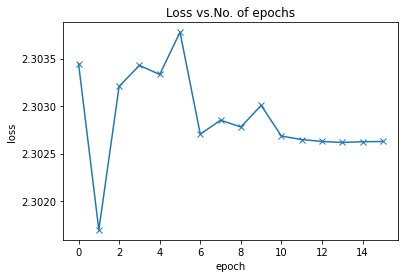

In [60]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss vs.No. of epochs");

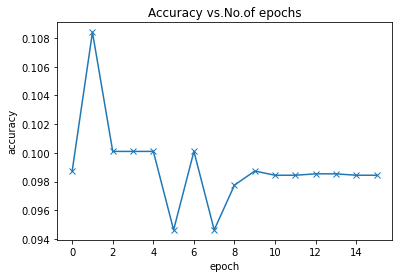

In [61]:
accuracies = [x['val_acc']for x in history]
plt.plot(accuracies,'-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs.No.of epochs');

In [62]:
!pip install jovian --upgrade -q

In [63]:
import jovian

In [79]:
jovian.commit(project='03-cifar10-feedforward', environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..


[jovian] Error: The detected/provided file "3_lesson_Project_by using other dataset.ipynb" does not exist. Please provide the correct notebook filename as the "filename" argument to "jovian.commit".


Testing with individual images
While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by recreating the test dataset with the ToTensor transform.


In [66]:
# Define test dataset
test_dataset = CIFAR10(root='data/',
                     train=False,
                     transform=ToTensor())
  

define a helper function predict_image, which returns the predicted label for a single image tensor.

In [67]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0),device)
    yb = model(xb)
    _,preds = torch.max(yb,dim=1)
    return preds[0].item()

Label: 3 ,Predicted: 4


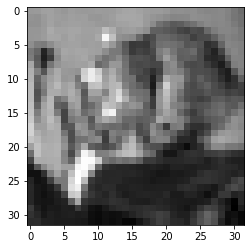

In [68]:
img, label = test_dataset[0]
plt.imshow(img[0],cmap='gray')
print('Label:',label,',Predicted:',predict_image(img, model))

Label: 7 ,Predicted: 4


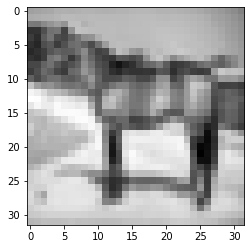

In [69]:
img, label = test_dataset[1839]
plt.imshow(img[0],cmap='gray')
print('Label:',label,',Predicted:',predict_image(img, model))

Label: 1 ,Predicted: 4


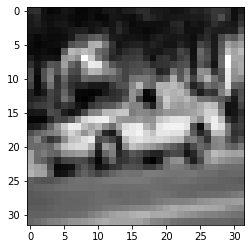

In [70]:
img, label = test_dataset[193]
plt.imshow(img[0],cmap='gray')
print('Label:',label,',Predicted:',predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.
As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [71]:
test_loader=DeviceDataLoader(DataLoader(test_dataset,batch_size=256),
                            device)
result = evaluate(model, test_loader)
result

{'val_loss': 2.3026809692382812, 'val_acc': 0.09765625}

We expect this to be similar to the accuracy/loss on the validation set.

In [72]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_loss'])

[jovian] Metrics logged.


In [73]:
torch.save(model.state_dict(),'cifar-100-python.tar.gz')


In [74]:
jovian.commit(project='03-cifar10-feedforward', 
              environment=None, 
              outputs=['cifar-100-python.tar.gz'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Creating a new project "erfq1031/03-cifar10-feedforward"
[jovian] Uploading notebook..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/erfq1031/03-cifar10-feedforward


'https://jovian.ai/erfq1031/03-cifar10-feedforward'